In a [previous blog post](http://flothesof.github.io/auto-diff-forward-mode.html), I examined how the forward mode of automatic differentiation worked using single-variable examples.

Having done that, I would like to now complete the perspective by adding something about the reverse mode of automatic differentiation. 

# A bit of theory

The reverse mode is a neat alternative to the forward mode. Put another way, both are computing the same derivatives but they do it in different ways.

To illustrate the difference between both, I’ve come up with the following table:


| case | forward | backward |
| ---- | ---- | ---- |
| what are we trying to solve for? | a dot derivative $$\dot{v_i} = \frac{\partial v_i}{\partial x}$$ | an adjoint variable $$\bar{v}_i = \frac{\partial y}{\partial v_i}$$ |
| what is the relationship between nodes? | $$\dot{v}_{i+1} = \frac{\partial f}{\partial v_i} \dot{v}_i$$ | $$\bar{v}_{i} = \frac{\partial f}{\partial v_i} \bar{v}_{i+1}$$ |

In the above, I denoted an output variable by $y$ and an input variable by $x$, while intermediate variables are denoted by $v_i$. This notation only applies to computational chains were at each stage we have the relationship $v_{i+1} = f(v_i)$. 

A key observation from the last table row is that the partial derivative $\frac{\partial f}{\partial v_i}$ evaluated numerically is part of both relationships. To say it differently: knowing the partial derivative on an edge of the computational graph, you can use it to either towards the input (adjoint derivative) or towards the output (dot derivative).

As an example, the following show the computational graph of $f(x) = \exp(\sin(\sin(x)))$ with its derivatives:

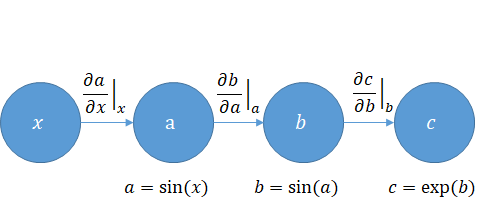

Applying the ideas from the previous blog post on the **forward mode**, we would traverse the chain from left to right, from inputs to outputs, from the inner function towards the outer.

In today’s post, we’ll do the opposite: go from the outputs to the inputs. However, we also need the specific values of the derivatives to go along this, so in practice we will first do a forward pass.

# Implementation

We will reuse the `Valder` class from last time to implement the reverse mode. The class allows to hold both function values and numerical derivative values at the evaluation point.

In [1]:
class Valder:
    def __init__(self, val=None, der=None):
        if val is None:
            raise RuntimeError("User should provide at least one value to init Valder class!")
        else:
            if der is None:
                # shorthand for a constant value
                self.val = val
                self.der = 0
            else:
                # general case
                self.val = val
                self.der = der
                
    def __repr__(self):
        return f"Valder(val={self.val}, der={self.der})"

Now, we want to define the chain by specifying the `exp` and `sin` functions. These will be written to operate on `Valder`s, as in the previous post, so that we can then use them in the reverse mode.

In [2]:
from math import sin as math_sin, cos as math_cos
from math import exp as math_exp

def sin(valder):
    x, dx = valder.val, valder.der
    return Valder(math_sin(x), math_cos(x))

def exp(valder):
    x, dx = valder.val, valder.der
    return Valder(math_exp(x), math_exp(x))

Finally, the specify the computational chain. It is here written from left to right, in the order of operation application.

In [3]:
chain = [sin, sin, exp]

With these elements in place, we can now implement the reverse mode. It first traverses the chain from left to right and then from right to left to return $\frac{\partial f}{\partial x}$ for $f(x) = \exp(\sin(\sin(x)))$.

In [4]:
def reverse_mode(chain, input_value, dy):
    
    # forward pass
    val = input_value
    derivs = []
    for op in chain:
        val = op(val)
        derivs.append(val.der)
        
    # backward pass
    der = dy
    for derivative_value in reversed(derivs):
        der *= derivative_value
    return val, der

val, der = reverse_mode(chain, Valder(2.0, 0), 1.)

val.val, der

(2.2013533791690376, -0.562752038662712)

Let’s compare this with a finite difference evaluation:

In [5]:
import numpy as np
eps = 1e-8

np.exp(np.sin(np.sin(2.))), (np.exp(np.sin(np.sin(2. + eps))) - np.exp(np.sin(np.sin(2.)))) / eps

(2.2013533791690376, -0.5627520671680486)

This seems to work!

Credits for finally understanding the approach and this specific example go to the following YT video: [Simple reverse-mode Autodiff in Python](https://www.youtube.com/watch?v=lWTSI55HC_c)

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20240212_AutoDiffReverseMode.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20240212_AutoDiffReverseMode.ipynb).*